In [87]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.ticker import MaxNLocator
import json
import ptitprince as pt
import pickle as pkl
# import contextily as ctx
from analysis import *
from ema_workbench import load_results
sns.set_theme(style="ticks")

In [89]:
# Load results
results = load_results('../results/scenarios=16, policies=16.tar.gz')
experiments, _ = results
experiments['scenario'] = experiments['scenario'].astype(int)

In [90]:
# Check whether all random seeds are unique
len(experiments['random_seed'].unique()), experiments['scenario'].max() - experiments['scenario'].min() + 1

(16, 16)

In [91]:
outcomes = prepare_outcomes_dataframe(results, add_policies=True)
outcomes.drop('years_in_poverty', axis=1, inplace=True)

In [92]:
# Convert columns to float
for col in outcomes.columns:
    if col not in ['scenario', 'policy', 'district', 'my_policy']:
        outcomes[col] = outcomes[col].astype(float)

## Graphs

In [79]:
# 'all', 'poor', 'poor_near_poor1.25', 'poor_near_poor2.0'
target_group_names = {'all+' : 'All', 'poor+' : 'Poor', 'poor_near_poor1.25+' : 'Poor and near-poor (1.25)', 'poor_near_poor2.0+' : 'Poor and near-poor (2.0)'}

In [133]:
target_group = 'poor_near_poor2.0+'
df = outcomes[outcomes['my_policy'].str.startswith(target_group)].copy()
df.rename({'district' : 'District'}, axis=1, inplace=True)
df['my_policy'] = df['my_policy'].astype('str')
df['my_policy'] = df['my_policy'].str.replace(f'{target_group}', '', regex=False)
df['my_policy'] = df['my_policy'].apply(lambda x: f'{x}%')
df.rename({'my_policy' : 'Top up'}, axis=1, inplace=True)
df['Top up'] = df['Top up'].sort_values()

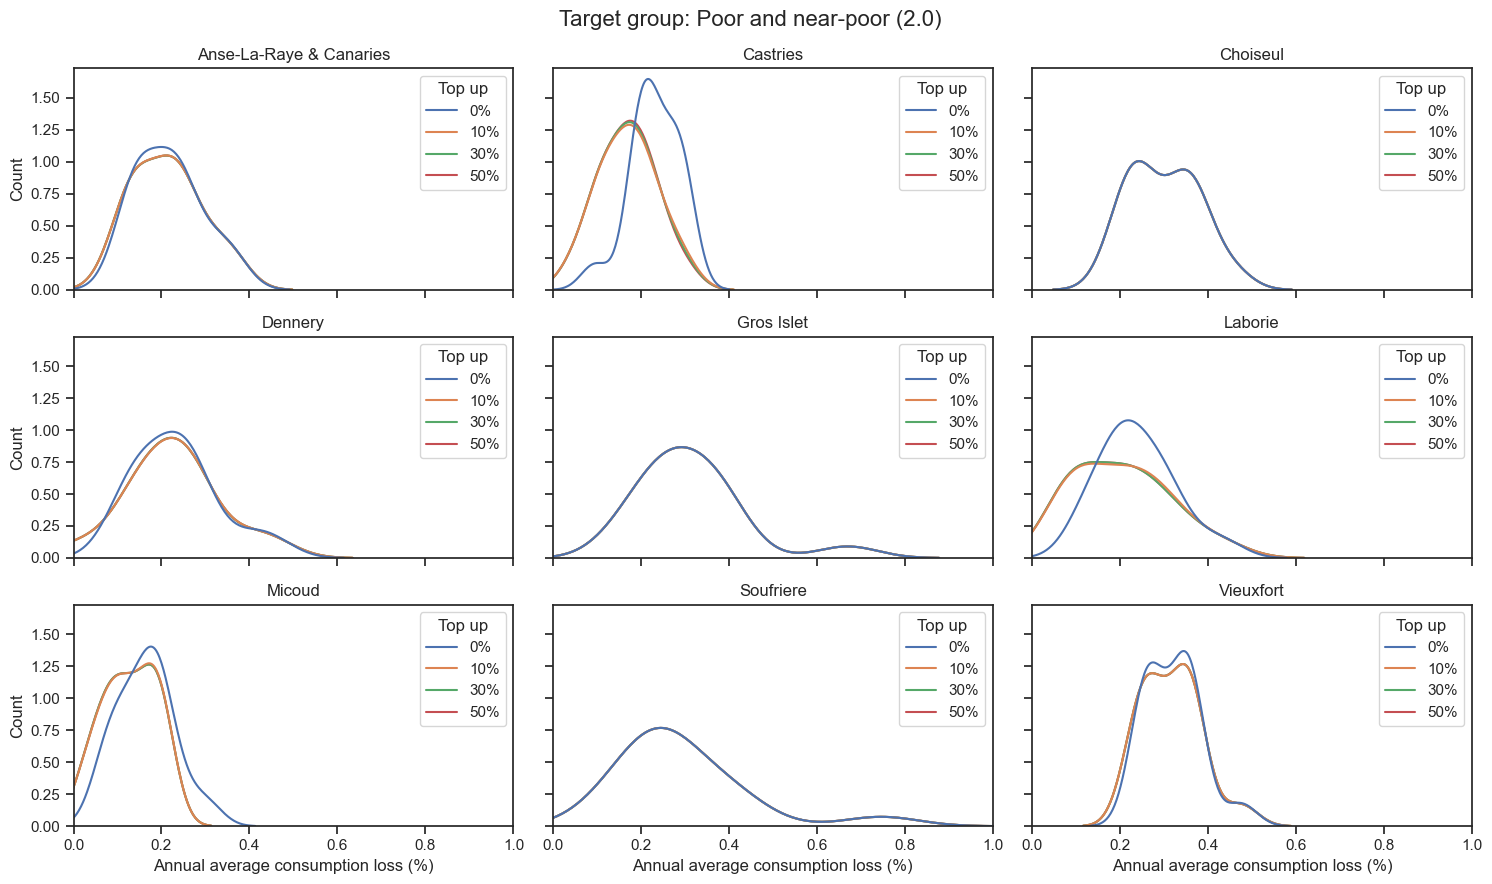

In [136]:
districts = df['District'].unique().tolist()
n_districts = len(districts)
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(5 * n_districts / 3, 3 * n_districts / 3), sharex=True, sharey=True)
colors = sns.color_palette('Set2', n_colors=len(districts))

# outcome_of_interest = 'n_new_poor'
outcome_of_interest = 'annual_average_consumption_loss_pct'

for district in districts:
    data = df[df['District'] == district][['Top up', outcome_of_interest]]
    data.sort_values('Top up', inplace=True)
    if district == 'AnseLaRayeCanaries':
        district_name = 'Anse-La-Raye & Canaries'
    else:
        district_name = district
    i = districts.index(district) // 3
    j = districts.index(district) % 3
    color = colors[districts.index(district)]
    sns.kdeplot(data=data, 
                 x=outcome_of_interest, 
                 hue='Top up', 
                 ax=ax[i, j], 
                 # multiple='stack', 
                 # shrink=.8,
                 # palette="ch:rot=-.25,hue=1,light=.75"
                 )
    ax[i, j].set_title(district_name)
    ax[i, j].set_xlabel('Annual average consumption loss (%)')
    # ax[i, j].set_xlabel('Number of new poor')
    ax[i, j].set_ylabel('Count')
    ax[i, j].set_xlim(0, 1)
fig.suptitle('Target group: ' + target_group_names[target_group], fontsize=16)
fig.tight_layout()

## Table

In [112]:
df = outcomes.drop(columns=['policy', 'scenario']).copy()

In [113]:
# Split values of a column into two columns
df[['target_group', 'top_up']] = df['my_policy'].str.split('+', expand=True)

In [102]:
outcomes_of_interest = ['annual_average_consumption_loss_pct', 'n_new_poor']
df.groupby(['district', 'target_group', 'top_up']).median()[outcomes_of_interest].head(25)

C:\Users\Mikhail\AppData\Local\Temp\ipykernel_8936\2083602244.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['district', 'target_group', 'top_up']).median()[outcomes_of_interest].head(25)


annual_average_consumption_loss_pct  \
district           target_group       top_up                                        
AnseLaRayeCanaries all                0                                  0.208937   
                                      10                                 0.002995   
                                      30                                 0.000000   
                                      50                                 0.000000   
                   poor               0                                  0.208937   
                                      10                                 0.158849   
                                      30                                 0.158849   
                                      50                                 0.158849   
                   poor_near_poor1.25 0                                  0.208937   
                                      10                                 0.208937   
                                      30                                 0.208937   
                                      50                                 0.208937   
                   poor_near_poor2.0  0                                  0.208937   
                                      10                                 0.208937   
                                      30                                 0.208937   
                                      50                                 0.208937   
Castries           all                0                                  0.230777   
                                      10                                 0.001930   
                                      30                                 0.000000   
                                      50                                 0.000000   
                   poor               0                                  0.230777   
                                      10                                 0.206903   
                                      30                                 0.206859   
                                      50                                 0.206859   
                   poor_near_poor1.25 0                                  0.230777   

                                              n_new_poor  
district           target_group       top_up              
AnseLaRayeCanaries all                0             75.5  
                                      10             0.0  
                                      30             0.0  
                                      50             0.0  
                   poor               0             75.5  
                                      10            75.5  
                                      30            75.5  
                                      50            75.5  
                   poor_near_poor1.25 0             75.5  
                                      10            75.5  
                                      30            75.5  
                                      50            75.5  
                   poor_near_poor2.0  0             75.5  
                                      10            75.5  
                                      30            75.5  
                                      50            75.5  
Castries           all                0            493.5  
                                      10             0.0  
                                      30             0.0  
                                      50             0.0  
                   poor               0            493.5  
                                      10           493.5  
                                      30           493.5  
                                      50           493.5  
                   poor_near_poor1.25 0            493.5

In [105]:
outcomes_of_interest = ['annual_average_consumption_loss_pct', 'n_new_poor']
df.drop('district', axis=1).groupby(['target_group', 'top_up']).mean()[outcomes_of_interest]

C:\Users\Mikhail\AppData\Local\Temp\ipykernel_8936\2616835071.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.drop('district', axis=1).groupby(['target_group', 'top_up']).mean()[outcomes_of_interest]


annual_average_consumption_loss_pct  n_new_poor
target_group       top_up                                                 
all                0                                  0.256888  151.437500
                   10                                 0.007397    1.708333
                   30                                 0.000498    0.201389
                   50                                 0.000248    0.000000
poor               0                                  0.256888  151.437500
                   10                                 0.228896  151.437500
                   30                                 0.228457  151.437500
                   50                                 0.228335  151.437500
poor_near_poor1.25 0                                  0.256888  151.437500
                   10                                 0.218020  151.437500
                   30                                 0.217479  151.437500
                   50                                 0.217429  151.437500
poor_near_poor2.0  0                                  0.256888  151.437500
                   10                                 0.240885  151.437500
                   30                                 0.240518  151.437500
                   50                                 0.240468  151.437500

In [ ]:
vertical = ['None', '10%', '30%', '50%']
horizontal = ['All', 'Poor', 'Poor & Near Poor (1.25)', 'Poor & Near Poor (2.0)']
columns = ['Vertical expansion', 'Horizontal expansion', 
           'Average reduction in consumption loss (%)', 
           'Average number of people prevented from falling into poverty']